<a href="https://colab.research.google.com/github/RenatoCes/Trabalho_Final_IA/blob/main/Modelo_IA_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install face_recognition tensorflow scikit-learn matplotlib
import os
import numpy as np
import tensorflow as tf
import face_recognition
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=25821fa31bcf8c3cf1aa595925f650c7d985635393b7125c3167b503393e95ce
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
Mounted at /content/drive


In [ ]:
resized_dataset_path = "/content/drive/MyDrive/Reconhecimento_Facial/test"
model_save_path = "/content/drive/MyDrive/Reconhecimento_Facial/saved_model"
history_save_path = "/content/drive/MyDrive/Reconhecimento_Facial/history.npy"
os.makedirs(model_save_path, exist_ok=True)

def process_images(image_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                img_path = os.path.join(image_dir, filename)
                img = face_recognition.load_image_file(img_path)
                face_locations = face_recognition.face_locations(img)

                if face_locations:
                    top, right, bottom, left = face_locations[0]
                    face_image = img[top:bottom, left:right]
                    pil_image = Image.fromarray(face_image).resize((224, 224))
                    images.append(np.array(pil_image) / 255.0)
                    labels.append(int(filename.split()[0]))
            except Exception as e:
                print(f"Erro ao processar a imagem {filename}: {e}")
    print(f"Total de imagens processadas: {len(images)}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

images, labels = process_images(resized_dataset_path)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(train_generator, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint])
model.save(model_save_path)

Total de imagens processadas: 4220
Epoch 1/50
106/106 [==============================] - 42s 330ms/step - loss: 0.7511 - accuracy: 0.5862 - val_loss: 0.6083 - val_accuracy: 0.7145
Epoch 2/50
106/106 [==============================] - 33s 313ms/step - loss: 0.6203 - accuracy: 0.6508 - val_loss: 0.5177 - val_accuracy: 0.7547
Epoch 3/50
106/106 [==============================] - 34s 317ms/step - loss: 0.5992 - accuracy: 0.6798 - val_loss: 0.5014 - val_accuracy: 0.7891
Epoch 4/50
106/106 [==============================] - 33s 314ms/step - loss: 0.5771 - accuracy: 0.7050 - val_loss: 0.4786 - val_accuracy: 0.7725
Epoch 5/50
106/106 [==============================] - 34s 318ms/step - loss: 0.5585 - accuracy: 0.7225 - val_loss: 0.4645 - val_accuracy: 0.7855
Epoch 6/50
106/106 [==============================] - 32s 301ms/step - loss: 0.5577 - accuracy: 0.7168 - val_loss: 0.5052 - val_accuracy: 0.7524
Epoch 7/50
106/106 [==============================] - 33s 310ms/step - loss: 0.5409 - accuracy:

27/27 [==============================] - 1s 18ms/step - loss: 0.1120 - accuracy: 0.9514
Loss: 0.11204294115304947
Accuracy: 0.9514217972755432
27/27 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       463
           1       0.97      0.92      0.94       381

    accuracy                           0.95       844
   macro avg       0.95      0.95      0.95       844
weighted avg       0.95      0.95      0.95       844



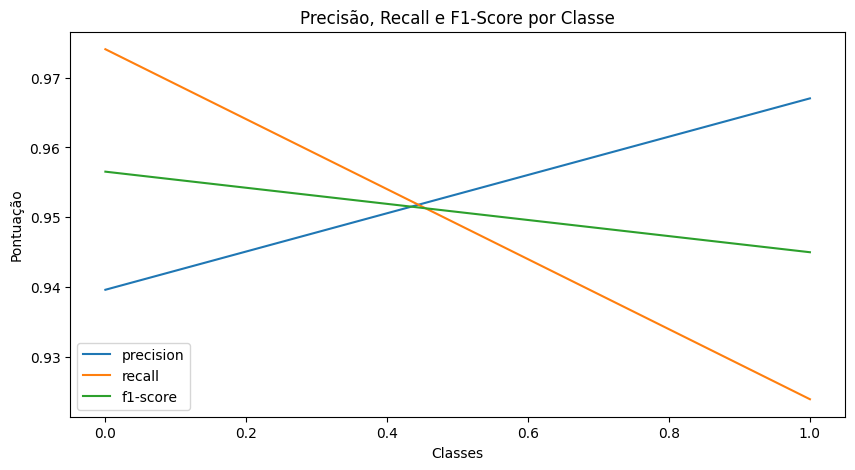

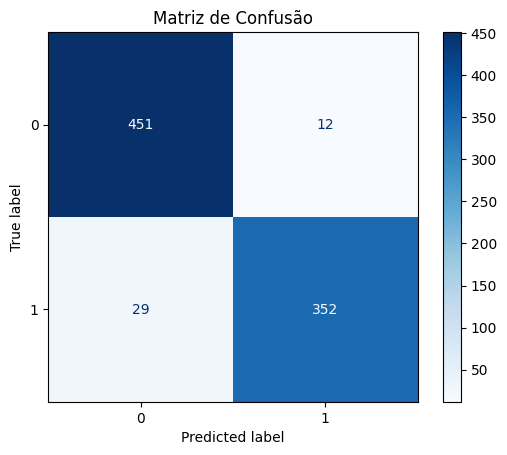

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprimir o relatório de classificação
report = classification_report(y_val, y_pred_classes, output_dict=True)
print(classification_report(y_val, y_pred_classes))
metrics_save_path = "/content/drive/MyDrive/Reconhecimento_Facial/metrics_graphs"
os.makedirs(metrics_save_path, exist_ok=True)

# Gerar e exportar gráficos de métricas
fig, ax = plt.subplots(figsize=(10, 5))

metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics):
    values = [report[str(label)][metric] for label in np.unique(y_val)]
    ax.plot(np.unique(y_val), values, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Pontuação')
ax.set_title('Precisão, Recall e F1-Score por Classe')
ax.legend()
plt.savefig(os.path.join(metrics_save_path, "metricas.png"))
plt.show()
cm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.savefig(os.path.join(metrics_save_path, "matriz_de_confusao.png"))
plt.show()


In [ ]:
new_dataset_path = "/content/drive/MyDrive/Reconhecimento_Facial/Converted"

X_new, y_new = process_images(new_dataset_path)

loss, accuracy = model.evaluate(X_new, y_new)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Fazer previsões com o novo conjunto de dados
y_pred = model.predict(X_new)
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprimir o relatório de classificação
report = classification_report(y_new, y_pred_classes, output_dict=True)
print(classification_report(y_new, y_pred_classes))

# Gerar e exportar gráficos de métricas para o novo conjunto de dados
fig, ax = plt.subplots(figsize=(10, 5))

for i, metric in enumerate(metrics):
    values = [report[str(label)][metric] for label in np.unique(y_new)]
    ax.plot(np.unique(y_new), values, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Pontuação')
ax.set_title('Precisão, Recall e F1-Score por Classe (Novo Dataset)')
ax.legend()
plt.savefig(os.path.join(metrics_save_path, "metricas_novo_dataset.png"))
plt.show()

cm = confusion_matrix(y_new, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_new))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão (Novo Dataset)')
plt.savefig(os.path.join(metrics_save_path, "matriz_de_confusao_novo_dataset.png"))
plt.show()
